# ACO OFDM

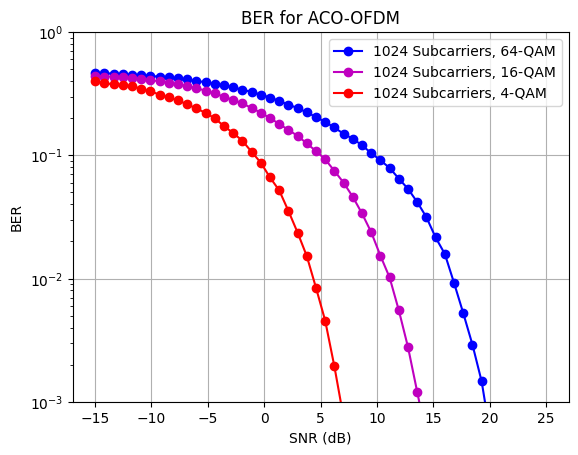

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import abc
from scipy.spatial.distance import cdist

class ACO:
    def __init__(self, Nsubcarrier, M):
        self.K = Nsubcarrier
        self.M = M
        self.data = np.random.binomial(n=1, p=0.5, size=self.K//4 * self.M)
        if M == 2:
            self.mapping = {(0,0):-1-1j,(1,0):-1+1j,(1,1):1+1j,(0,1):1-1j}
        elif M == 4:
            self.mapping = {(0,0,0,0) : -3-3j,
                            (0,0,0,1) : -3-1j,
                            (0,0,1,0) : -3+3j,
                            (0,0,1,1) : -3+1j,
                            (0,1,0,0) : -1-3j,
                            (0,1,0,1) : -1-1j,
                            (0,1,1,0) : -1+3j,
                            (0,1,1,1) : -1+1j,
                            (1,0,0,0) :  3-3j,
                            (1,0,0,1) :  3-1j,
                            (1,0,1,0) :  3+3j,
                            (1,0,1,1) :  3+1j,
                            (1,1,0,0) :  1-3j,
                            (1,1,0,1) :  1-1j,
                            (1,1,1,0) :  1+3j,
                            (1,1,1,1) :  1+1j}
        elif M == 6:
            self.mapping = {(0,0,0,0,0,0) : +7+7j,
                            (0,0,0,0,0,1) : +5+7j,
                            (0,0,0,0,1,0) : +1+7j,
                            (0,0,0,0,1,1) : +3+7j,
                            (0,0,0,1,0,0) : -7+7j,
                            (0,0,0,1,0,1) : -5+7j,
                            (0,0,0,1,1,0) : -1+7j,
                            (0,0,0,1,1,1) : -3+7j,
                            (0,0,1,0,0,0) : +7+5j,
                            (0,0,1,0,0,1) : +5+5j,
                            (0,0,1,0,1,0) : +1+5j,
                            (0,0,1,0,1,1) : +3+5j,
                            (0,0,1,1,0,0) : -7+5j,
                            (0,0,1,1,0,1) : -5+5j,
                            (0,0,1,1,1,0) : -1+5j,
                            (0,0,1,1,1,1) : -3+5j,#00
                            (0,1,0,0,0,0) : +7+1j,
                            (0,1,0,0,0,1) : +5+1j,
                            (0,1,0,0,1,0) : +1+1j,
                            (0,1,0,0,1,1) : +3+1j,
                            (0,1,0,1,0,0) : -7+1j,
                            (0,1,0,1,0,1) : -5+1j,
                            (0,1,0,1,1,0) : -1+1j,
                            (0,1,0,1,1,1) : -3+1j,
                            (0,1,1,0,0,0) : +7+3j,
                            (0,1,1,0,0,1) : +5+3j,
                            (0,1,1,0,1,0) : +1+3j,
                            (0,1,1,0,1,1) : +3+3j,
                            (0,1,1,1,0,0) : -7+3j,
                            (0,1,1,1,0,1) : -5+3j,
                            (0,1,1,1,1,0) : -1+3j,
                            (0,1,1,1,1,1) : -3+3j,# 10
                            (1,0,0,0,0,0) : +7-7j,
                            (1,0,0,0,0,1) : +5-7j,
                            (1,0,0,0,1,0) : +1-7j,
                            (1,0,0,0,1,1) : +3-7j,
                            (1,0,0,1,0,0) : -7-7j,
                            (1,0,0,1,0,1) : -5-7j,
                            (1,0,0,1,1,0) : -1-7j,
                            (1,0,0,1,1,1) : -3-7j,
                            (1,0,1,0,0,0) : +7-5j,
                            (1,0,1,0,0,1) : +5-5j,
                            (1,0,1,0,1,0) : +1-5j,
                            (1,0,1,0,1,1) : +3-5j,
                            (1,0,1,1,0,0) : -7-5j,
                            (1,0,1,1,0,1) : -5-5j,
                            (1,0,1,1,1,0) : -1-5j,
                            (1,0,1,1,1,1) : -3-5j,#11
                            (1,1,0,0,0,0) : +7-1j,
                            (1,1,0,0,0,1) : +5-1j,
                            (1,1,0,0,1,0) : +1-1j,
                            (1,1,0,0,1,1) : +3-1j,
                            (1,1,0,1,0,0) : -7-1j,
                            (1,1,0,1,0,1) : -5-1j,
                            (1,1,0,1,1,0) : -1-1j,
                            (1,1,0,1,1,1) : -3-1j,
                            (1,1,1,0,0,0) : +7-3j,
                            (1,1,1,0,0,1) : +5-3j,
                            (1,1,1,0,1,0) : +1-3j,
                            (1,1,1,0,1,1) : +3-3j,
                            (1,1,1,1,0,0) : -7-3j,
                            (1,1,1,1,0,1) : -5-3j,
                            (1,1,1,1,1,0) : -1-3j,
                            (1,1,1,1,1,1) : -3-3j
                            }
        
        self.SNRdB = np.linspace(-15, 25)
        self.symbol = self.S_P(self.data, M)
        self.symbol_mapped = self.Mapping(self.symbol)
        self.HermittianSymetry = self.hermitian_aco(self.symbol_mapped, Nsubcarrier)
        self.AfterIFFT = self.IFFT(self.HermittianSymetry)
        self.AfterClipping = self.Clipping(self.AfterIFFT)
        demapping_table = {v: k for k, v in self.mapping.items()}

    def calculate_ber(self):
      self.BER = []

      demapping_table = {v: k for k, v in self.mapping.items()}

      for snr_db in self.SNRdB:
          ber_iteration = []

          for _ in range(100):
              self.ACO_RX = self.channel(self.AfterClipping, snr_db)
              self.AfterFFT = self.FFT(self.ACO_RX)
              self.symbol_ext = self.message_ext(self.AfterFFT)
              self.Afterdemap, _ = self.demapping(self.symbol_ext, demapping_table)
              self.dataouput = self.P_S(self.Afterdemap)
              ber_iteration.append(np.mean(self.data != self.dataouput))


          self.BER.append(np.mean(ber_iteration))

    def S_P(self, bits, M):
        return bits.reshape(-1, M)
    
    # def generate_constellation(self, M):
    #     n = np.arange(0,  2**M)
    #     a = np.asarray([x ^ (x >> 1) for x in n])
    #     D = np.sqrt(2 ** M).astype(int)
    #     a = np.reshape(a, (D, D))
    #     oddRows = np.arange(start=1, stop=D, step=2)
    #     a[oddRows, :] = np.fliplr(a[oddRows, :])
    #     nGray = np.reshape(a, 2 ** M)
    #     (x, y) = np.divmod(nGray, D)
    #     Ax = 2 * x + 1 - D
    #     Ay = 2 * y + 1 - D
    #     constellation = Ax + 1j * Ay
    #     return constellation

    # def qam_mapping(self, M):
    #     self.mapping = {}
    #     num_bits_per_symbol = int(np.log2(M))
    #     for i, point in enumerate(self.generate_constellation(int(np.log2(M)))):
    #         bit_sequence = tuple(map(int, f"{i:0{num_bits_per_symbol}b}"))
    #         self.mapping[bit_sequence] = point
    #     return self.mapping

    def Mapping(self, bits):
        return np.array([self.mapping[tuple(b)] for b in bits])

    def hermitian_aco(self, symbol_mapped, K):
        SYMETRICarray = np.zeros(K, dtype=complex)

        odd_index = 1
        for i in range(len(symbol_mapped)):
            if odd_index < K // 2:
                SYMETRICarray[odd_index] = symbol_mapped[i]
                SYMETRICarray[K - odd_index] = np.conjugate(symbol_mapped[i])
                odd_index += 2
        return SYMETRICarray

    def IFFT(self, HermittianSymetry):
        return np.fft.ifft(HermittianSymetry)

    def Clipping(self, AfterIFFT):
        clippedsignal = np.maximum(AfterIFFT, 0)
        return clippedsignal

    def channel(self, signal, snr_db):
        Channel_response = np.array([1])
        Y = np.convolve(signal, Channel_response)[:len(signal)]
        signal_power = np.mean(np.abs(Y) ** 2)
        noise_power = signal_power * 10 ** (-snr_db / 10)
        noise = np.sqrt(noise_power / 2) * np.random.randn(*Y.shape)
        return Y + noise

    def FFT(self, ACO_RX):
        return np.fft.fft(ACO_RX)

    def message_ext(self, AfterFFT):
        symbol_ext = []
        for i in range(len(AfterFFT)//2):
            if i % 2 != 0:
                symbol_ext.append(2 * AfterFFT[i])
        return np.array(symbol_ext)

    def demapping(self, mapping, demapping_table):
        constel = np.array([x for x in demapping_table.keys()])
        dis = abs(mapping.reshape((-1, 1)) - constel.reshape((1, -1)))
        constel_index = dis.argmin(axis=1)
        HDecision = constel[constel_index]
        return np.vstack([demapping_table[C] for C in HDecision]), HDecision

    def P_S(self, bits):
        return bits.reshape((-1,))

    def plot_signals(self):

        real_hermitian = np.real(self.HermittianSymetry)
        imag_hermitian = np.imag(self.HermittianSymetry)

        real_ifft = np.real(self.AfterIFFT)
        imag_ifft = np.imag(self.AfterIFFT)

        real_clipped = np.real(self.AfterClipping)
        imag_clipped = np.imag(self.AfterClipping)

        subcarrier_index = np.arange(self.K)

        plt.figure(figsize=(20, 5))


        plt.subplot(1, 2, 1)
        plt.stem(subcarrier_index, real_hermitian, linefmt='b-', markerfmt='bo', basefmt='r-', label='Re')
        plt.stem(subcarrier_index, imag_hermitian, linefmt='r-', markerfmt='ro', basefmt='r-', label='Im')
        plt.title('After Hermitian Symmetry')
        plt.xlabel('Subcarrier Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)


        for idx in subcarrier_index:
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)

        plt.figure(figsize=(20,5))
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(real_ifft)), real_ifft, 'b-', label='Before Clipping')
        plt.plot(np.arange(len(real_clipped)), real_clipped, 'r--', label='After Clipping')
        plt.title('Before and After Clipping')
        plt.xlabel('Time slot')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)


        for idx in range(0, len(real_ifft), self.K // 10):
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)
        for idx in range(0, len(real_clipped), self.K // 10):
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)
        for idx in subcarrier_index:
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()




Cam = ACO(1024, 6)
Pink = ACO(1024, 4)
Cam1 = ACO(1024, 2)
Cam.calculate_ber()
Pink.calculate_ber()
Cam1.calculate_ber()
plt.ylim(10**-3,1)
plt.plot(Cam.SNRdB, Cam.BER, 'bo-', label='1024 Subcarriers, 64-QAM')
plt.plot(Pink.SNRdB, Pink.BER, 'mo-', label='1024 Subcarriers, 16-QAM')
plt.plot(Cam1.SNRdB, Cam1.BER, 'ro-', label='1024 Subcarriers, 4-QAM')

plt.semilogy()
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.title('BER for ACO-OFDM')
plt.grid(True)
plt.show()



# DCO OFDM

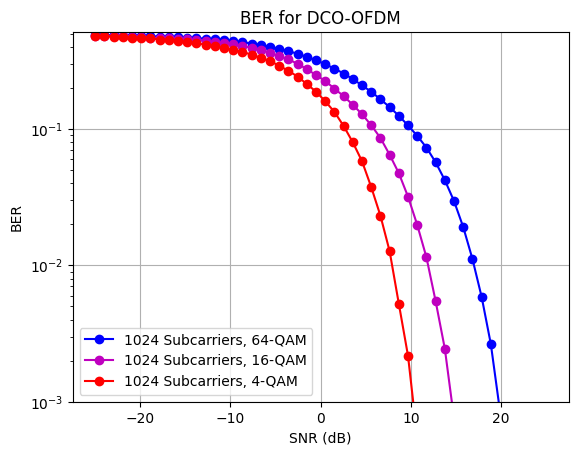

In [8]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

class DCO:
    def __init__(self, Nsubcarrier, M, DC_bias):
        self.K = Nsubcarrier
        self.M = M
        self.DC_bias = DC_bias
        if M == 2:
            self.mapping = {(0,0):-1-1j,(1,0):-1+1j,(1,1):1+1j,(0,1):1-1j}
        elif M == 4:
            self.mapping = {(0,0,0,0) : -3-3j,
                            (0,0,0,1) : -3-1j,
                            (0,0,1,0) : -3+3j,
                            (0,0,1,1) : -3+1j,
                            (0,1,0,0) : -1-3j,
                            (0,1,0,1) : -1-1j,
                            (0,1,1,0) : -1+3j,
                            (0,1,1,1) : -1+1j,
                            (1,0,0,0) :  3-3j,
                            (1,0,0,1) :  3-1j,
                            (1,0,1,0) :  3+3j,
                            (1,0,1,1) :  3+1j,
                            (1,1,0,0) :  1-3j,
                            (1,1,0,1) :  1-1j,
                            (1,1,1,0) :  1+3j,
                            (1,1,1,1) :  1+1j}
        elif M == 6:
            self.mapping = {(0,0,0,0,0,0) : +7+7j,
                            (0,0,0,0,0,1) : +5+7j,
                            (0,0,0,0,1,0) : +1+7j,
                            (0,0,0,0,1,1) : +3+7j,
                            (0,0,0,1,0,0) : -7+7j,
                            (0,0,0,1,0,1) : -5+7j,
                            (0,0,0,1,1,0) : -1+7j,
                            (0,0,0,1,1,1) : -3+7j,
                            (0,0,1,0,0,0) : +7+5j,
                            (0,0,1,0,0,1) : +5+5j,
                            (0,0,1,0,1,0) : +1+5j,
                            (0,0,1,0,1,1) : +3+5j,
                            (0,0,1,1,0,0) : -7+5j,
                            (0,0,1,1,0,1) : -5+5j,
                            (0,0,1,1,1,0) : -1+5j,
                            (0,0,1,1,1,1) : -3+5j,#00
                            (0,1,0,0,0,0) : +7+1j,
                            (0,1,0,0,0,1) : +5+1j,
                            (0,1,0,0,1,0) : +1+1j,
                            (0,1,0,0,1,1) : +3+1j,
                            (0,1,0,1,0,0) : -7+1j,
                            (0,1,0,1,0,1) : -5+1j,
                            (0,1,0,1,1,0) : -1+1j,
                            (0,1,0,1,1,1) : -3+1j,
                            (0,1,1,0,0,0) : +7+3j,
                            (0,1,1,0,0,1) : +5+3j,
                            (0,1,1,0,1,0) : +1+3j,
                            (0,1,1,0,1,1) : +3+3j,
                            (0,1,1,1,0,0) : -7+3j,
                            (0,1,1,1,0,1) : -5+3j,
                            (0,1,1,1,1,0) : -1+3j,
                            (0,1,1,1,1,1) : -3+3j,# 10
                            (1,0,0,0,0,0) : +7-7j,
                            (1,0,0,0,0,1) : +5-7j,
                            (1,0,0,0,1,0) : +1-7j,
                            (1,0,0,0,1,1) : +3-7j,
                            (1,0,0,1,0,0) : -7-7j,
                            (1,0,0,1,0,1) : -5-7j,
                            (1,0,0,1,1,0) : -1-7j,
                            (1,0,0,1,1,1) : -3-7j,
                            (1,0,1,0,0,0) : +7-5j,
                            (1,0,1,0,0,1) : +5-5j,
                            (1,0,1,0,1,0) : +1-5j,
                            (1,0,1,0,1,1) : +3-5j,
                            (1,0,1,1,0,0) : -7-5j,
                            (1,0,1,1,0,1) : -5-5j,
                            (1,0,1,1,1,0) : -1-5j,
                            (1,0,1,1,1,1) : -3-5j,#11
                            (1,1,0,0,0,0) : +7-1j,
                            (1,1,0,0,0,1) : +5-1j,
                            (1,1,0,0,1,0) : +1-1j,
                            (1,1,0,0,1,1) : +3-1j,
                            (1,1,0,1,0,0) : -7-1j,
                            (1,1,0,1,0,1) : -5-1j,
                            (1,1,0,1,1,0) : -1-1j,
                            (1,1,0,1,1,1) : -3-1j,
                            (1,1,1,0,0,0) : +7-3j,
                            (1,1,1,0,0,1) : +5-3j,
                            (1,1,1,0,1,0) : +1-3j,
                            (1,1,1,0,1,1) : +3-3j,
                            (1,1,1,1,0,0) : -7-3j,
                            (1,1,1,1,0,1) : -5-3j,
                            (1,1,1,1,1,0) : -1-3j,
                            (1,1,1,1,1,1) : -3-3j
                            }
        

        self.SNRdB = np.linspace(-25, 25,num=50)
        self.data = np.random.binomial(n=1, p=0.5, size=(self.K//2 - 1) * self.M)
        self.symbol = self.S_P(self.data, M)
        self.demapping_table = {v: k for k, v in self.mapping.items()}
        self.symbol_mapped = self.Mapping(self.symbol)
        self.HermittianSymmetry = self.hermitian_dco(self.symbol_mapped, Nsubcarrier)
        self.AfterIFFT = self.IFFT(self.HermittianSymmetry)
        self.AfterAdd = self.add_dcbias(self.AfterIFFT, DC_bias)
        self.BER = []

    def S_P(self, bits, M):
        return bits.reshape(-1, M)

    def Mapping(self, bits):
        return np.array([self.mapping[tuple(b)] for b in bits])

    def hermitian_dco(self, symbol_mapped, K):
        SYMETRICarray = np.zeros(K, dtype=complex)

        index = 1
        for i in range(len(symbol_mapped)):
            if index < K // 2:
                SYMETRICarray[index] = symbol_mapped[i]
                SYMETRICarray[K - index] = np.conjugate(symbol_mapped[i])
                index += 1
        return SYMETRICarray

    def IFFT(self, HermittianSymmetry):
        return np.fft.ifft(HermittianSymmetry)

    def add_dcbias(self, AfterIFFT, DC_bias):
        return AfterIFFT + DC_bias

    def channel(self, signal, snr_db):
        Channel_response = np.array([1])
        Y = np.convolve(signal, Channel_response)[:len(signal)]
        signal_power = np.mean(np.abs(Y) ** 2)
        noise_power = signal_power * 10 ** (-snr_db / 10)
        noise = np.sqrt(noise_power / 2) * np.random.randn(*Y.shape)
        return Y + noise

    def FFT(self, DCO_RX):
        return np.fft.fft(DCO_RX)

    def message_ext(self, AfterFFT):
        symbol_ext = []

        index = 1
        for i in range(1,len(AfterFFT) // 2):
            if index < self.K // 2:
                symbol_ext.append(AfterFFT[i])
                index += 1
        return np.array(symbol_ext)

    def demapping(self, received_symbols):
        constel = np.array([x for x in self.demapping_table.keys()])
        dis = abs(received_symbols.reshape((-1, 1)) - constel.reshape((1, -1)))
        constel_index = dis.argmin(axis=1)
        HDecision = constel[constel_index]
        return np.vstack([self.demapping_table[C] for C in HDecision])

    def P_S(self, bits):
        return bits.reshape((-1,))

    def calculate_ber(self):
        for snr_db in self.SNRdB:
            self.A = np.zeros(100)
            for i in range(100):
                DCO_RX = self.channel(self.AfterAdd, snr_db)
                AfterFFT = self.FFT(DCO_RX)
                symbol_ext = self.message_ext(AfterFFT)
                AfterDemap = self.demapping(symbol_ext)
                bits_est = self.P_S(AfterDemap)
                self.A[i] = np.mean(self.data != bits_est)
            self.BER.append(np.mean(self.A))

    def plot_signals(self):


        real_ifft = np.real(self.AfterIFFT)
        imag_ifft = np.imag(self.AfterIFFT)

        real_dc_offset = np.real(self.AfterAdd)
        imag_dc_offset = np.imag(self.AfterAdd)
        subcarrier_index = np.arange(self.K)

        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(real_ifft)), real_ifft, 'b-', label='Before DC Offset')
        plt.plot(np.arange(len(real_dc_offset)), real_dc_offset, 'r--', label='After DC Offset')
        plt.title('Before and After DC Offset')
        plt.xlabel('Time slot')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        for idx in range(0, len(real_ifft), self.K // 10):
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)
        for idx in range(0, len(real_dc_offset), self.K // 10):
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)
        for idx in subcarrier_index:
            plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)

        plt.tight_layout()
        plt.show()

Cam = DCO(1024, 6, 0.05)
Pink = DCO(1024, 4, 0.05)
Pink1 = DCO(1024, 2, 0.05)


Cam.calculate_ber()
Pink.calculate_ber()
Pink1.calculate_ber()

plt.plot(Cam.SNRdB, Cam.BER, 'bo-', label='1024 Subcarriers, 64-QAM')
plt.plot(Pink.SNRdB, Pink.BER, 'mo-', label='1024 Subcarriers, 16-QAM')
plt.plot(Pink1.SNRdB, Pink1.BER, 'ro-', label='1024 Subcarriers, 4-QAM')
plt.ylim(10**-3)
plt.semilogy()
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.title('BER for DCO-OFDM')
plt.grid(True)
plt.show()
